<a href="https://colab.research.google.com/github/JG-geek/Diffusion_Models/blob/main/deblurring_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup and imports

In [5]:
%pip install -q diffusers

In [6]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


## load dataset

In [7]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.06MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



input shape: torch.Size([8, 1, 28, 28])
labesl: tensor([7, 9, 2, 2, 8, 8, 9, 4])


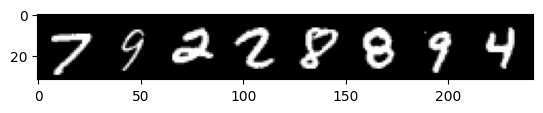

In [8]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
# visualize few images
images, labels = next(iter(train_dataloader))
print(f"input shape: {images.shape}")
print(f"labesl: {labels}")
plt.imshow(torchvision.utils.make_grid(images)[0], cmap='grey')

## UNet2DModel

(from diffusers library)

In [10]:
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,   # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "AttnUpBlock2D",
        "UpBlock2D",    # a regular ResNet upsampling block
    ),
)

In [4]:
## sanity check
model = model.to(device)
input = torch.randn(10, 1, 28, 28).to(device)
output = model(input)
print(f"output shape: {output.shape}")

NameError: name 'model' is not defined

## corrupt the data

In [3]:
import numpy as np
import cv2  # OpenCV for image blurring
def smooth_gaussian(image, kernel_size=5, iterations=3):
    """
    Apply Gaussian blurring multiple times to smooth the image more aggressively.

    Parameters:
    - image: Input image tensor of shape (1, H, W).
    - kernel_size: Size of the Gaussian kernel.
    - iterations: Number of times to apply the blur.

    Returns:
    - Smoothed image tensor of shape (1, H, W).
    """
    image_np = image.cpu().numpy().squeeze()  # Move to CPU before converting
    for _ in range(iterations):  # Apply multiple blurring passes
        image_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), 0)
    return torch.tensor(image_np).unsqueeze(0).to(image.device)  # Convert back to tensor and move to original device
